# Solving a New Keynesian model with Julia

This file is part of a computational appendix that accompanies the paper.

> MATLAB, Python, Julia: What to Choose in Economics?
>
> Coleman, Lyon, Maliar, and Maliar (2017)


For some details regarding the model solved in this file, please see the
[companion notebook that describes the model](http://bookshelf.quantecon.org/submission/59fa1b45145fc3772b0cef82).

In order to run the codes in this file you will need to install and configure a
few Julia packages. We recommend downloading
[JuliaPro](https://juliacomputing.com/products/juliapro.html) and/or following
the instructions on
[quantecon.org](https://lectures.quantecon.org/py/getting_started.html).

Once your Julia installation is up and running, there are a few additional packages
you will need in order to run the code here. We use the
[InstantiateFromURL](https://github.com/QuantEcon/InstantiateFromURL.jl) pacakge to make
it easy to get all required packages set up in your Julia environment.  If you have not
previously installed the `InstantiateFromURL` package you will need to uncomment the line
`pkg"add InstantiateFromURL"` and run the cell below.

In [2]:
using Pkg
# pkg"add InstantiateFromURL"
using InstantiateFromURL: activate_github_path
activate_github_path("sglyon/CLMMJuliaPythonMatlab", path="NewKeynesian/julia", activate=true, force=true)

## Julia Code

The Julia version of our algorithm is implemented as a few functions defined on
a core type named `Model`. This type is itself composed of three different types
that hold the model parameters, steady state, and grids needed to describe the
numerical model. Before we get to the types, we need to bring in some
dependencies:

In [3]:
# for plotting the output
using PlotlyJS

# for constructing Sobol sequences
using Sobol
# for basis matrix of complete monomials and monomial quadrature rules
using BasisMatrices, QuantEcon
using MAT
using Parameters

# standard library components
using Printf  # printing messages
using Statistics  # computing `mean`
using Random: seed!
using LinearAlgebra: diagm, cholesky, dot
using InteractiveUtils: versioninfo
using DelimitedFiles: writedlm

seed!(42);  # set seed for reproducibility

┌ Info: Recompiling stale cache file /Users/sglyon/.julia/compiled/v1.1/PlotlyJS/1r9Ld.ji for PlotlyJS [f0f68f2c-4968-5e81-91da-67840de0976a]
└ @ Base loading.jl:1184


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-14428889923614605427\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-646382844124682983\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/assetserver/19958735580ebcd56dd81b254493fee912933a90-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-14428889923614605427\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

┌ Warning: Please upgrade Blink for a smoother integration with WebIO.
│   caller = ip:0x0
└ @ Core :-1
┌ Info: Recompiling stale cache file /Users/sglyon/.julia/compiled/v1.1/BasisMatrices/65PSC.ji for BasisMatrices [08854c51-b66b-5062-a90d-8e7ae4547a49]
└ @ Base loading.jl:1184


## Types

First we have the `Params` type, which holds all the model parameters as well
as the paramters that drive the algorithm.

In [4]:
@with_kw struct Params
    zlb::Bool = true
    γ::Float64 = 1.0       # Utility-function parameter
    β::Float64 = 0.99      # Discount factor
    ϑ::Float64 = 2.09      # Utility-function parameter
    ϵ::Float64 = 4.45      # Parameter in the Dixit-Stiglitz aggregator
    ϕ_y::Float64 = 0.07    # Parameter of the Taylor rule
    ϕ_π::Float64 = 2.21    # Parameter of the Taylor rule
    μ::Float64 = 0.82      # Parameter of the Taylor rule
    Θ::Float64 = 0.83      # Share of non-reoptimizing firms (Calvo's pricing)
    πstar::Float64 = 1.0   # Target (gross) inflation rate
    gbar::Float64 = 0.23   # Steady-state share of government spending in output

    # autocorrelation coefficients
    ρηR::Float64 = 0.0   # See process (28) in MM (2015)
    ρηa::Float64 = 0.95  # See process (22) in MM (2015)
    ρηL::Float64 = 0.25  # See process (16) in MM (2015)
    ρηu::Float64 = 0.92  # See process (15) in MM (2015)
    ρηB::Float64 = 0.0   # See process (17) in MM (2015)
    ρηG::Float64 = 0.95  # See process (26) in MM (2015)

    # standard deviations
    σηR::Float64 = 0.0028  # See process (28) in MM (2015)
    σηa::Float64 = 0.0045  # See process (22) in MM (2015)
    σηL::Float64 = 0.05    # See process (16) in MM (2015)
    σηu::Float64 = 0.0054  # See process (15) in MM (2015)
    σηB::Float64 = 0.001   # See process (17) in MM (2015)
    σηG::Float64 = 0.0038  # See process (26) in MM (2015)

    # algorithm parameters
    deg::Int = 2          # max degree of complete monomial
    damp::Float64 = 0.1   # dampening parameter for coefficient update
    tol::Float64 = 1e-7   # Tolerance for stopping iterations
    grid_kind::Symbol = :sobol  # type of grid (:sobol or :random)
end

function grid_size(p::Params)
    Dict(1 => 20, 2 => 100, 3 => 300, 4 => 1000, 5 => 2000)[p.deg]
end

# returns the covariance matrix for the 6 shocks in the model
vcov(p::Params) = diagm(0 => [p.σηR^2, p.σηa^2, p.σηL^2, p.σηu^2, p.σηB^2, p.σηG^2])

vcov (generic function with 1 method)

Next we have a type called `SteadyState` that is intended to hold the
deterministic steady state realization for each variable in the model.

In [5]:
struct SteadyState
    Yn::Float64
    Y::Float64
    π::Float64
    δ::Float64
    L::Float64
    C::Float64
    F::Float64
    S::Float64
    R::Float64
    w::Float64
end

function SteadyState(p::Params)
    Yn_ss = exp(p.gbar)^(p.γ/(p.ϑ+p.γ))
    Y_ss  = Yn_ss
    π_ss  = 1.0
    δ_ss  = 1.0
    L_ss  = Y_ss/δ_ss
    C_ss  = (1-p.gbar)*Y_ss
    F_ss  = C_ss^(-p.γ)*Y_ss/(1-p.β*p.Θ*π_ss^(p.ϵ-1))
    S_ss  = L_ss^p.ϑ*Y_ss/(1-p.β*p.Θ*π_ss^p.ϵ)
    R_ss  = π_ss/p.β
    w_ss  = (L_ss^p.ϑ)*(C_ss^p.γ)

    SteadyState(Yn_ss, Y_ss, π_ss, δ_ss, L_ss, C_ss, F_ss, S_ss, R_ss, w_ss)
end

SteadyState

Given an instance of `Params` and `SteadyState`, we can construct the grid on
which we will solve the model.

The `Grids` type holds this grid as well as matrices used to compute
expectations.

To match the Python and Matlab versions of the code, the constructor for `Grids`
below loads pre-generated grids from a `.mat` file for both Sobol and random
grids. This ensures that the exact same code is run in each language. If you
would like to generate the grids in pure Julia, you can set the `grid_source`
keyword argument to `:julia`

In [6]:
struct Grids
    # period t grids
    ηR::Vector{Float64}
    ηa::Vector{Float64}
    ηL::Vector{Float64}
    ηu::Vector{Float64}
    ηB::Vector{Float64}
    ηG::Vector{Float64}
    R::Vector{Float64}
    δ::Vector{Float64}

    # combined matrix and complete polynomial version of it
    X::Matrix{Float64}
    X0_G::Dict{Int,Matrix{Float64}}

    # quadrature weights and nodes
    ϵ_nodes::Matrix{Float64}
    ω_nodes::Vector{Float64}

    # period t+1 grids at all shocks
    ηR1::Matrix{Float64}
    ηa1::Matrix{Float64}
    ηL1::Matrix{Float64}
    ηu1::Matrix{Float64}
    ηB1::Matrix{Float64}
    ηG1::Matrix{Float64}
end

function Grids(p::Params, ss::SteadyState; grid_source::Symbol=:mat)
    m = grid_size(p)
    σ = [p.σηR p.σηa p.σηL p.σηu p.σηB p.σηG]
    ρ = [p.ρηR p.ρηa p.ρηL p.ρηu p.ρηB p.ρηG]
    if p.grid_kind == :sobol
        if grid_source == :mat
            # Values of exogenous state variables are in the interval +/- σ/sqrt(1-ρ^2)
            _path = joinpath(@__DIR__, "..", "Sobol_grids.mat")
            s = (matread(_path)["Sobol_grids"][1:m, :])::Matrix{Float64}
            sη = s[:, 1:6]
            η = (
                -2σ .+ 4.0 .* (maximum(sη, dims=1).-sη) ./
                (maximum(sη, dims=1).-minimum(sη, dims=1)).*σ
            )./sqrt.(1 .- ρ.^2)

            R = 1 .+ 0.05 .* (maximum(s[:, 7]).-s[:, 7]) ./ (maximum(s[:, 7])-minimum(s[:, 7]))
            δ = 0.95 .+ 0.05 .* (maximum(s[:, 8]).-s[:, 8]) ./ (maximum(s[:, 8])-minimum(s[:, 8]))
        else
            ub = [2 * p.σηR / sqrt(1 - p.ρηR^2),
                  2 * p.σηa / sqrt(1 - p.ρηa^2),
                  2 * p.σηL / sqrt(1 - p.ρηL^2),
                  2 * p.σηu / sqrt(1 - p.ρηu^2),
                  2 * p.σηB / sqrt(1 - p.ρηB^2),
                  2 * p.σηG / sqrt(1 - p.ρηG^2),
                  1.05,  # R
                  1.0    # δ
                 ]
            lb = -ub
            lb[[7, 8]] = [1.0, 0.95]  # adjust lower bound for R and δ

            # construct SobolSeq
            s = SobolSeq(length(ub), ub, lb)
            # skip(s, m)  # See note in README of Sobol.jl

            # gather points
            seq = Array{Float64}(8, m)
            for i in 1:m
                seq[:, i] = next(s)
            end
            seq = seq'  # transpose so variables are in columns
            η = seq[:, 1:6]
            R  = seq[:, 7]
            δ  = seq[:, 8]
        end
    else  # assume random
        # Values of exogenous state variables are distributed uniformly
        # in the interval +/- std/sqrt(1-rho_nu^2)
        if grid_source == :mat
            _path = joinpath(@__DIR__, "..", "random_grids.mat")
            s = (matread(_path)["random_grids"][1:m, :])::Matrix{Float64}
        else
            s = rand(m, 8)
        end
        sη = s[:, 1:6]
        η = @. (-2*σ + 4*σ*sη) / sqrt(1-ρ^2)

        # Values of endogenous state variables are distributed uniformly
        # in the intervals [1 1.05] and [0.95 1], respectively
        R = 1 + 0.05 * s[:, 7]
        δ = 0.95 + 0.05 * s[:, 8]
    end
    ηR = η[:, 1]
    ηa = η[:, 2]
    ηL = η[:, 3]
    ηu = η[:, 4]
    ηB = η[:, 5]
    ηG = η[:, 6]

    X = [log.(R) log.(δ) ηR ηa ηL ηu ηB ηG]
    X0_G = Dict(
        1 => complete_polynomial(X, 1),
        p.deg => complete_polynomial(X, p.deg)
    )

    ϵ_nodes, ω_nodes = qnwmonomial1(vcov(p))

    ηR1 = p.ρηR.*ηR .+ ϵ_nodes[:, 1]'
    ηa1 = p.ρηa.*ηa .+ ϵ_nodes[:, 2]'
    ηL1 = p.ρηL.*ηL .+ ϵ_nodes[:, 3]'
    ηu1 = p.ρηu.*ηu .+ ϵ_nodes[:, 4]'
    ηB1 = p.ρηB.*ηB .+ ϵ_nodes[:, 5]'
    ηG1 = p.ρηG.*ηG .+ ϵ_nodes[:, 6]'

    Grids(
        ηR, ηa, ηL, ηu, ηB, ηG, R, δ, X, X0_G, ϵ_nodes, ω_nodes, ηR1, ηa1, ηL1,
        ηu1, ηB1, ηG1
    )
end

Grids

Finally, we construct the `Model` type, which has an instance of `Params`,
`SteadyState` and `Grids` as its three fields.

In [7]:
struct Model
    p::Params
    s::SteadyState
    g::Grids
end

function Model(;grid_source=:mat, kwargs...)
    p = Params(;kwargs...)
    s = SteadyState(p)
    g = Grids(p, s; grid_source=grid_source)
    Model(p, s, g)
end

Base.show(io::IO, m::Model) = println(io, "New Keynesian model")

Now that we have a model, we will construct one more helper function that takes
the control variables $(S, F, C)$ and shocks $(\delta, R, \eta_G, \eta_a,
\eta_L, \eta_R)$ and applies equilibrium conditions to produce $(\pi, \delta',
Y, L, Y_n, R')$. We will use this function in both the solution and simulation
routines below.

In [8]:
function Base.step(m::Model, S, F, C, δ0, R0, ηG, ηa, ηL, ηR)
    @unpack Θ, ϵ, gbar, ϑ, γ, β, μ, ϕ_π, ϕ_y, πstar = m.p
    πs = m.s.π

    # Compute pie(t) from condition (35) in MM (2015)
    π0 = @. ((1-(1-Θ)*(S/F)^(1-ϵ))/Θ)^(1/(ϵ-1))

    # Compute delta(t) from condition (36) in MM (2015)
    δ1 = @. ((1-Θ)*((1-Θ*π0^(ϵ-1))/(1-Θ))^(ϵ/(ϵ-1))+Θ*π0^ϵ/δ0)^(-1.0)

    # Compute Y(t) from condition (38) in MM (2015)
    Y0 = @. C/(1-gbar/exp(ηG))

    # Compute L(t) from condition (37) in MM (2015)
    L0 = @. Y0/exp(ηa)/δ1

    #  Compute Yn(t) from condition (31) in MM (2015)
    Yn0 = @. (exp(ηa)^(1+ϑ)*(1-gbar/exp(ηG))^(-γ)/exp(ηL))^(1/(ϑ+γ))

    # Compute R(t) from conditions (27), (39) in MM (2015) -- Taylor rule
    R1 = @. πstar / β * (R0*β/πstar)^μ*((π0/πstar)^ϕ_π * (Y0/Yn0)^ϕ_y)^(1-μ)*exp(ηR)

    π0, δ1, Y0, L0, Yn0, R1
end

### Solution routine

In [9]:
# construct an initial guess for the solution
function initial_coefs(m::Model, degree)
    npol = size(m.g.X0_G[degree], 2)
    coefs = fill(1e-5, npol, 3)
    coefs[1, :] = [m.s.S, m.s.F, m.s.C^(-m.p.γ)]
    coefs
end

function solve(m::Model; verbose::Bool=false)
    # simplify notation
    n, n_nodes = size(m.g.ηR, 1), length(m.g.ω_nodes)

    ## allocate memory
    # euler equations
    e = zeros(n, 3)

    # previous iteration S, F, C
    S0_old_G = ones(n)
    F0_old_G = ones(n)
    C0_old_G = ones(n)

    # current iteration S, F, C
    S0_new_G = ones(n)
    F0_new_G = ones(n)
    C0_new_G = ones(n)

    # future S, F, C
    S1 = zeros(n, n_nodes)
    F1 = zeros(n, n_nodes)
    C1 = zeros(n, n_nodes)
    π1 = zeros(n, n_nodes)

    local coefs, start_time

    degs = m.p.deg > 1 ? [1, m.p.deg] : [m.p.deg]

    for deg in degs
        # set up matrices for this degree
        X0_G = m.g.X0_G[deg]

        # future basis matrix for S, F, C
        X1 = Array{Float64}(undef, n, n_complete(8, deg))

        # initialize coefs
        if deg <= 1
            coefs = initial_coefs(m, deg)
        else
            # for higher order, start with degree 2 coefficients
            coefs = X0_G\e
            # old_coefs = copy(coefs)
            # coefs = initial_coefs(m, deg)
            # coefs[1:size(old_coefs, 1), :] = old_coefs
        end

        err = 1.0
        it = 0

        start_time = time()
        # solve at this degree of complete polynomial
        while err > m.p.tol
            it += 1;
            # Current choices (at t)
            # ------------------------------
            S0 = X0_G*coefs[:, 1]                # Compute S(t) using coefs
            F0 = X0_G*coefs[:, 2]                # Compute F(t) using coefs
            C0 = X0_G*coefs[:, 3]
            C0 .^= (-1/m.p.γ)                    # Compute C(t) using coefs

            π0, δ1, Y0, L0, Yn0, R1 = step(m, S0, F0, C0, m.g.δ, m.g.R, m.g.ηG,
                                           m.g.ηa, m.g.ηL, m.g.ηR)

            if m.p.zlb R1 .= max.(R1, 1.0) end

            for u in 1:n_nodes
                # Form complete polynomial of degree "Degree" (at t+1) on future state
                complete_polynomial!(
                    X1,
                    hcat(log.(R1), log.(δ1), m.g.ηR1[:, u], m.g.ηa1[:, u],
                         m.g.ηL1[:, u], m.g.ηu1[:, u], m.g.ηB1[:, u], m.g.ηG1[:, u]),
                    deg
                )

                S1[:, u] = X1*coefs[:, 1]                # Compute S(t+1)
                F1[:, u] = X1*coefs[:, 2]                # Compute F(t+1)
                C1[:, u] = (X1*coefs[:, 3]).^(-1/m.p.γ)  # Compute C(t+1)
            end

            # Compute next-period π using condition
            # (35) in MM (2015)
            @. π1 = ((1-(1-m.p.Θ).*(S1./F1).^(1-m.p.ϵ))/m.p.Θ).^(1/(m.p.ϵ-1))

            # Evaluate conditional expectations in the Euler equations
            #---------------------------------------------------------
            e[:, 1] = @.(exp(m.g.ηu)*exp(m.g.ηL)*L0^m.p.ϑ*Y0/exp(m.g.ηa) + (m.p.β*m.p.Θ*π1^m.p.ϵ*S1))*m.g.ω_nodes
            e[:, 2] = @.(exp(m.g.ηu)*C0^(-m.p.γ)*Y0 + (m.p.β*m.p.Θ*π1^(m.p.ϵ-1)*F1))*m.g.ω_nodes
            e[:, 3] = @.(m.p.β*exp(m.g.ηB)/exp(m.g.ηu)*R1*((exp(m.g.ηu1).*C1^(-m.p.γ)/π1)))*m.g.ω_nodes

            # Variables of the current iteration
            #-----------------------------------
            copy!(S0_new_G, S0)
            copy!(F0_new_G, F0)
            copy!(C0_new_G, C0)

            # Compute and update the coefficients of the decision functions
            # -------------------------------------------------------------
            coefs_hat = X0_G\e   # Compute the new coefficients of the decision
                                 # functions using a backslash operator

            # Update the coefficients using damping
            coefs = m.p.damp*coefs_hat + (1-m.p.damp)*coefs

            # Evaluate the percentage (unit-free) difference between the values
            # on the grid from the previous and current iterations
            # -----------------------------------------------------------------
            # The convergence criterion is adjusted to the damping parameters
            err = mean(abs, 1.0.-S0_new_G./S0_old_G) +
                  mean(abs, 1.0.-F0_new_G./F0_old_G) +
                  mean(abs, 1.0.-C0_new_G./C0_old_G)

            if (it % 20 == 0) && verbose
                @printf "On iteration %d err is %6.7e\n" it err
            end

            # Store the obtained values for S(t), F(t), C(t) on the grid to
            # be used on the subsequent iteration in Section 10.2.6
            #-----------------------------------------------------------------------
            copy!(S0_old_G, S0_new_G)
            copy!(F0_old_G, F0_new_G)
            copy!(C0_old_G, C0_new_G)

        end
    end

    coefs, time() - start_time
end

solve (generic function with 1 method)

### Simulation

In [10]:
struct Simulation
    # shocks
    ηR::Vector{Float64}
    ηa::Vector{Float64}
    ηL::Vector{Float64}
    ηu::Vector{Float64}
    ηB::Vector{Float64}
    ηG::Vector{Float64}

    # variables
    δ::Vector{Float64}
    R::Vector{Float64}
    S::Vector{Float64}
    F::Vector{Float64}
    C::Vector{Float64}
    π::Vector{Float64}
    Y::Vector{Float64}
    L::Vector{Float64}
    Yn::Vector{Float64}
    w::Vector{Float64}
end

function Simulation(m::Model, coefs::Matrix)

    # 11. Simualating a time-series solution
    #---------------------------------------
    _path = joinpath(@__DIR__, "..", "epsi_test_NK.mat")
    rands = (matread(_path)["epsi_test_NK"])::Matrix{Float64}
    capT = size(rands, 1)

    # Initialize the values of 6 exogenous shocks
    #--------------------------------------------
    ηR = zeros(capT)
    ηa = zeros(capT)
    ηL = zeros(capT)
    ηu = zeros(capT)
    ηB = zeros(capT)
    ηG = zeros(capT)

    # Generate the series for shocks
    #-------------------------------
    @inbounds for t in 1:capT-1
        ηR[t+1] = m.p.ρηR*ηR[t] + m.p.σηR*rands[t, 1]
        ηa[t+1] = m.p.ρηa*ηa[t] + m.p.σηa*rands[t, 2]
        ηL[t+1] = m.p.ρηL*ηL[t] + m.p.σηL*rands[t, 3]
        ηu[t+1] = m.p.ρηu*ηu[t] + m.p.σηu*rands[t, 4]
        ηB[t+1] = m.p.ρηB*ηB[t] + m.p.σηB*rands[t, 5]
        ηG[t+1] = m.p.ρηG*ηG[t] + m.p.σηG*rands[t, 6]
    end

    δ  = ones(capT+1) # Time series of delta(t)
    R  = ones(capT+1) # Time series of R(t)
    S  = Array{Float64}(undef, capT)   # Time series of S(t)
    F  = Array{Float64}(undef, capT)   # Time series of F(t)
    C  = Array{Float64}(undef, capT)   # Time series of C(t)
    π  = Array{Float64}(undef, capT)   # Time series of π(t)
    Y  = Array{Float64}(undef, capT)   # Time series of Y(t)
    L  = Array{Float64}(undef, capT)   # Time series of L(t)
    Yn = Array{Float64}(undef, capT)   # Time series of Yn(t)
    w  = Array{Float64}(undef, capT)

    pol_bases = Array{Float64}(undef, 1, size(coefs, 1))
    @inbounds for t in 1:capT
        # Construct the matrix of explanatory variables "pol_bases" on the series
        # of state variables; columns of "pol_bases" are given by the basis
        # functions of the polynomial of degree 2
        complete_polynomial!(
            pol_bases,
            hcat(log(R[t]), log(δ[t]), ηR[t], ηa[t], ηL[t], ηu[t], ηB[t], ηG[t]),
            m.p.deg
        )
        S[t], F[t], MU = pol_bases*coefs
        C[t] = (MU).^(-1/m.p.γ)

        π[t], δ[t+1], Y[t], L[t], Yn[t], R[t+1] = step(m, S[t], F[t], C[t], δ[t],
                                                       R[t], ηG[t], ηa[t], ηL[t], ηR[t])

        # Compute real wage
        w[t] = exp(ηL[t])*(L[t]^m.p.ϑ)*(C[t]^m.p.γ)

        # If ZLB is imposed, set R(t)=1 if ZLB binds
        if m.p.zlb; R[t+1] = max(R[t+1],1.0); end
    end

    Simulation(ηR, ηa, ηL, ηu, ηB, ηG, δ, R, S, F, C, π, Y, L, Yn, w)
end

Simulation

### Accuracy

In [11]:
struct Residuals
    resids::Matrix{Float64}
end

function Residuals(m::Model, coefs::Matrix, sim::Simulation; burn::Int=200)
    capT = length(sim.w)
    resids = zeros(9, capT)

    # Integration method for evaluating accuracy
    # ------------------------------------------
    # Monomial integration rule with 2N^2+1 nodes
    ϵ_nodes, ω_nodes = qnwmonomial2(vcov(m.p))
    n_nodes = length(ω_nodes)

    # Allocate for arrays needed in the loop
    basis_mat = Array{Float64}(undef, n_nodes, 8)
    X1 = Array{Float64}(undef, n_nodes, size(coefs, 1))

    ηR1 = Array{Float64}(undef, n_nodes)
    ηa1 = Array{Float64}(undef, n_nodes)
    ηL1 = Array{Float64}(undef, n_nodes)
    ηu1 = Array{Float64}(undef, n_nodes)
    ηB1 = Array{Float64}(undef, n_nodes)
    ηG1 = Array{Float64}(undef, n_nodes)

    for t in 1:capT                 # For each given point,
        # Take the corresponding value for shocks at t
        #---------------------------------------------
        ηR0 = sim.ηR[t]  # ηR(t)
        ηa0 = sim.ηa[t]  # ηa(t)
        ηL0 = sim.ηL[t]  # ηL(t)
        ηu0 = sim.ηu[t]  # ηu(t)
        ηB0 = sim.ηB[t]  # ηB(t)
        ηG0 = sim.ηG[t]  # ηG(t)

        # Exctract time t values for all other variables (and t+1 for R, δ)
        #------------------------------------------------------------------
        R0  = sim.R[t]   # R(t-1)
        δ0  = sim.δ[t]   # δ(t-1)
        R1  = sim.R[t+1] # R(t)
        δ1  = sim.δ[t+1] # δ(t)

        L0  = sim.L[t]   # L(t)
        Y0  = sim.Y[t]   # Y(t)
        Yn0 = sim.Yn[t]  # Yn(t)
        π0  = sim.π[t]   # π(t)
        S0  = sim.S[t]   # S(t)
        F0  = sim.F[t]   # F(t)
        C0  = sim.C[t]   # C(t)

        # Fill basis matrix with R1, δ1 and shocks
        #-----------------------------------------
        # Note that we do not premultiply by standard deviations as ϵ_nodes
        # already include them. All these variables are vectors of length n_nodes
        copy!(ηR1, ηR0*m.p.ρηR .+ ϵ_nodes[:, 1])
        copy!(ηa1, ηa0*m.p.ρηa .+ ϵ_nodes[:, 2])
        copy!(ηL1, ηL0*m.p.ρηL .+ ϵ_nodes[:, 3])
        copy!(ηu1, ηu0*m.p.ρηu .+ ϵ_nodes[:, 4])
        copy!(ηB1, ηB0*m.p.ρηB .+ ϵ_nodes[:, 5])
        copy!(ηG1, ηG0*m.p.ρηG .+ ϵ_nodes[:, 6])

        basis_mat[:, 1] .= log.(R1)
        basis_mat[:, 2] .= log.(δ1)
        basis_mat[:, 3] = ηR1
        basis_mat[:, 4] = ηa1
        basis_mat[:, 5] = ηL1
        basis_mat[:, 6] = ηu1
        basis_mat[:, 7] = ηB1
        basis_mat[:, 8] = ηG1

        # Future choices at t+1
        #----------------------
        # Form a complete polynomial of degree "Degree" (at t+1) on future state
        # variables; n_nodes-by-npol
        complete_polynomial!(X1, basis_mat, m.p.deg)

        # Compute S(t+1), F(t+1) and C(t+1) in all nodes using coefs
        S1 = X1*coefs[:, 1]
        F1 = X1*coefs[:, 2]
        C1 = (X1*coefs[:, 3]).^(-1/m.p.γ)

        # Compute π(t+1) using condition (35) in MM (2015)
        π1 = @. ((1-(1-m.p.Θ)*(S1./F1).^(1-m.p.ϵ))/m.p.Θ).^(1/(m.p.ϵ-1))

        # Compute residuals for each of the 9 equilibrium conditions
        #-----------------------------------------------------------
        resids[1, t] = 1-dot(ω_nodes,
            @. (exp(ηu0)*exp(ηL0)*L0^m.p.ϑ*Y0/exp(ηa0) + m.p.β*m.p.Θ*π1.^m.p.ϵ.*S1)/S0
        )
        resids[2, t] = 1 - dot(ω_nodes,
            @. (exp(ηu0)*C0^(-m.p.γ)*Y0 + m.p.β*m.p.Θ*π1.^(m.p.ϵ-1).*F1)/F0
        )
        resids[3, t] = 1.0 -dot(ω_nodes,
            @. (m.p.β*exp(ηB0)/exp(ηu0)*R1*exp.(ηu1).*C1.^(-m.p.γ)./π1)/C0^(-m.p.γ)
        )
        resids[4, t] = 1-((1-m.p.Θ*π0^(m.p.ϵ-1))/(1-m.p.Θ))^(1/(1-m.p.ϵ))*F0/S0
        resids[5, t] = 1-((1-m.p.Θ)*((1-m.p.Θ*π0^(m.p.ϵ-1))/(1-m.p.Θ))^(m.p.ϵ/(m.p.ϵ-1)) + m.p.Θ*π0^m.p.ϵ/δ0)^(-1)/δ1
        resids[6, t] = 1-exp(ηa0)*L0*δ1/Y0
        resids[7, t] = 1-(1-m.p.gbar/exp(ηG0))*Y0/C0
        resids[8, t] = 1-(exp(ηa0)^(1+m.p.ϑ)*(1-m.p.gbar/exp(ηG0))^(-m.p.γ)/exp(ηL0))^(1/(m.p.ϑ+m.p.γ))/Yn0
        resids[9, t] = 1-m.s.π/m.p.β*(R0*m.p.β/m.s.π)^m.p.μ*((π0/m.s.π)^m.p.ϕ_π * (Y0/Yn0)^m.p.ϕ_y)^(1-m.p.μ)*exp(ηR0)/R1   # Taylor rule

        # If the ZLB is imposed and R>1, the residuals in the Taylor rule (the
        # 9th equation) are zero
        if m.p.zlb && R1 <= 1; resids[9, t] = 0.0; end

    end
    # discard the first burn observations
    Residuals(resids[:, burn+1:end])
end

Statistics.mean(r::Residuals) = log10(mean(abs, r.resids))
Base.max(r::Residuals) = log10(maximum(abs, r.resids))
max_E(r::Residuals) = log10.(maximum(abs, r.resids, dims=2))[:]

max_E (generic function with 1 method)

### Running the code

Now that we've done all the hard work to define the model, its solution and
simulation, and accuracy checks, let's put things together and run the code!

In [12]:
function ensurefile(url, localpath)
    if !isfile(localpath)
        println("Downloading $url to $localpath")
        download(url, localpath)
    end
end


function main(m=Model(); io::IO=stdout)
    ensurefile("https://github.com/sglyon/CLMMJuliaPythonMatlab/raw/master/NewKeynesian/Sobol_grids.mat", "Sobol_grids.mat")
    ensurefile("https://github.com/sglyon/CLMMJuliaPythonMatlab/raw/master/NewKeynesian/epsi_test_NK.mat", "epsi_test_NK.mat")
    ensurefile("https://github.com/sglyon/CLMMJuliaPythonMatlab/raw/master/NewKeynesian/random_grids.mat", "random_grids.mat")
    coefs, solve_time = solve(m);

    # simulate the model
    ts = time(); sim = Simulation(m, coefs); simulation_time = time() - ts

    # check accuracy
    tr = time(); resids = Residuals(m, coefs, sim); resids_time = time() - tr

    err_by_eq = max_E(resids)
    l1 = mean(resids)
    l∞ = max(resids)
    tot_time = solve_time + simulation_time + resids_time
    round3(x) = round(x, digits=3)
    round2(x) = round(x, digits=2)

    println(io, "Solver time (in seconds): $(solve_time)")
    println(io, "Simulation time (in seconds): $(simulation_time)")
    println(io, "Residuals time (in seconds): $(resids_time)")
    println(io, "total time (in seconds): $(tot_time)")
    println(io, "\nAPPROXIMATION ERRORS (log10):");
    println(io, "\ta) mean error in the model equations: $(round3(l1))");
    println(io, "\tb) max error in the model equations: $(round3(l∞))");
    println(io, "\tc) max error by equation:$(round3.(err_by_eq))");

    solve_time, simulation_time, resids_time, coefs, sim, resids

    t = 1:100
    p1 = plot([scatter(x=t, y=sim.S[t], name="S"), scatter(x=t, y=sim.F[t], name="F")],
              Layout(title="Figure 1a. S and F"))

    p2 = plot([scatter(x=t, y=sim.Y[t], name="Y"), scatter(x=t, y=sim.Yn[t], name="Yn")],
              Layout(title="Figure 1b. Output and natural output"))

    p3 = plot([scatter(x=t, y=sim.C[t], name="C"), scatter(x=t, y=sim.L[t], name="L")],
              Layout(title="Figure 1c. Consumption and labor"))

    p4 = plot([scatter(x=t, y=sim.δ[t], name="δ"), scatter(x=t, y=sim.R[t], name="R"),
               scatter(x=t, y=sim.π[t], name="π")],
              Layout(title="Figure 1d. Distortion, interest rate and inflation"))

    p = [p1 p2; p3 p4]
    p.plot.layout["width"] = 1000
    p.plot.layout["height"] = 600

    p, solve_time, simulation_time, resids_time, coefs, sim, resids, l1, l∞
end

main (generic function with 2 methods)

In [13]:
function build_paper_table()
    # call main once to precompile all routines
    main()

    to_csv = []
    push!(to_csv, ["pi_star", "zlb", "degree", "solve_time", "l_1", "l_inf"])

    this_dir = @__DIR__

    open(joinpath(this_dir, "output.log"), "w") do f
        for params in [Dict(:πstar=>1.0, :zlb=>false),
                       Dict(:πstar=>1.0, :zlb=>true),
                       Dict(:πstar=>1 + 0.0598/4, :zlb=>false)]
            for deg in 1:5
                println("Starting $params and deg=$deg")
                m = Model(;grid_kind=:sobol, deg=deg, params...)

                println(f, "Starting $params and deg=$deg")
                solve_time, l1, linf = main(m, io=f)[[2, 8, 9]]
                push!(to_csv, [params[:πstar], params[:zlb], deg, solve_time, l1, linf])
                @show to_csv
                println(f, "\n"^5)
                flush(f)
            end
        end
        versioninfo(f, verbose=true)
    end

    writedlm(
        joinpath(this_dir, "output_osx.csv"),
        permutedims(hcat(to_csv...), (2, 1)), ','
    )
end

build_paper_table (generic function with 1 method)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   164  100   164    0     0    261      0 --:--:-- --:--:-- --:--:--   261


100 37041  100 37041    0     0  41250      0 --:--:-- --:--:-- --:--:-- 1090k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   165  100   165    0     0    277      0 --:--:-- --:--:-- --:--:--   277
 44  614k   44  271k    0     0   286k      0  

100  614k  100  614k    0     0   604k      0  0:00:01  0:00:01 --:--:-- 5121k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   165  100   165    0     0    303      0 --:--:-- --:--:-- --:--:--   303
100  118k  100  118k    0     0   142k      0 --:--:-- --:--:-- --:--:--  142k


Solver time (in seconds): 0.551569938659668
Simulation time (in seconds): 0.10648202896118164
Residuals time (in seconds): 0.9602680206298828
total time (in seconds): 1.6183199882507324

APPROXIMATION ERRORS (log10):
	a) mean error in the model equations: -4.399
	b) max error in the model equations: -2.165
	c) max error by equation:[-2.165, -2.452, -2.355, -15.0, -Inf, -15.654, -15.654, -Inf, -Inf]


┌ Warning: Accessing `scope.id` is deprecated, use `scopeid(scope)` instead.
│   caller = ip:0x0
└ @ Core :-1


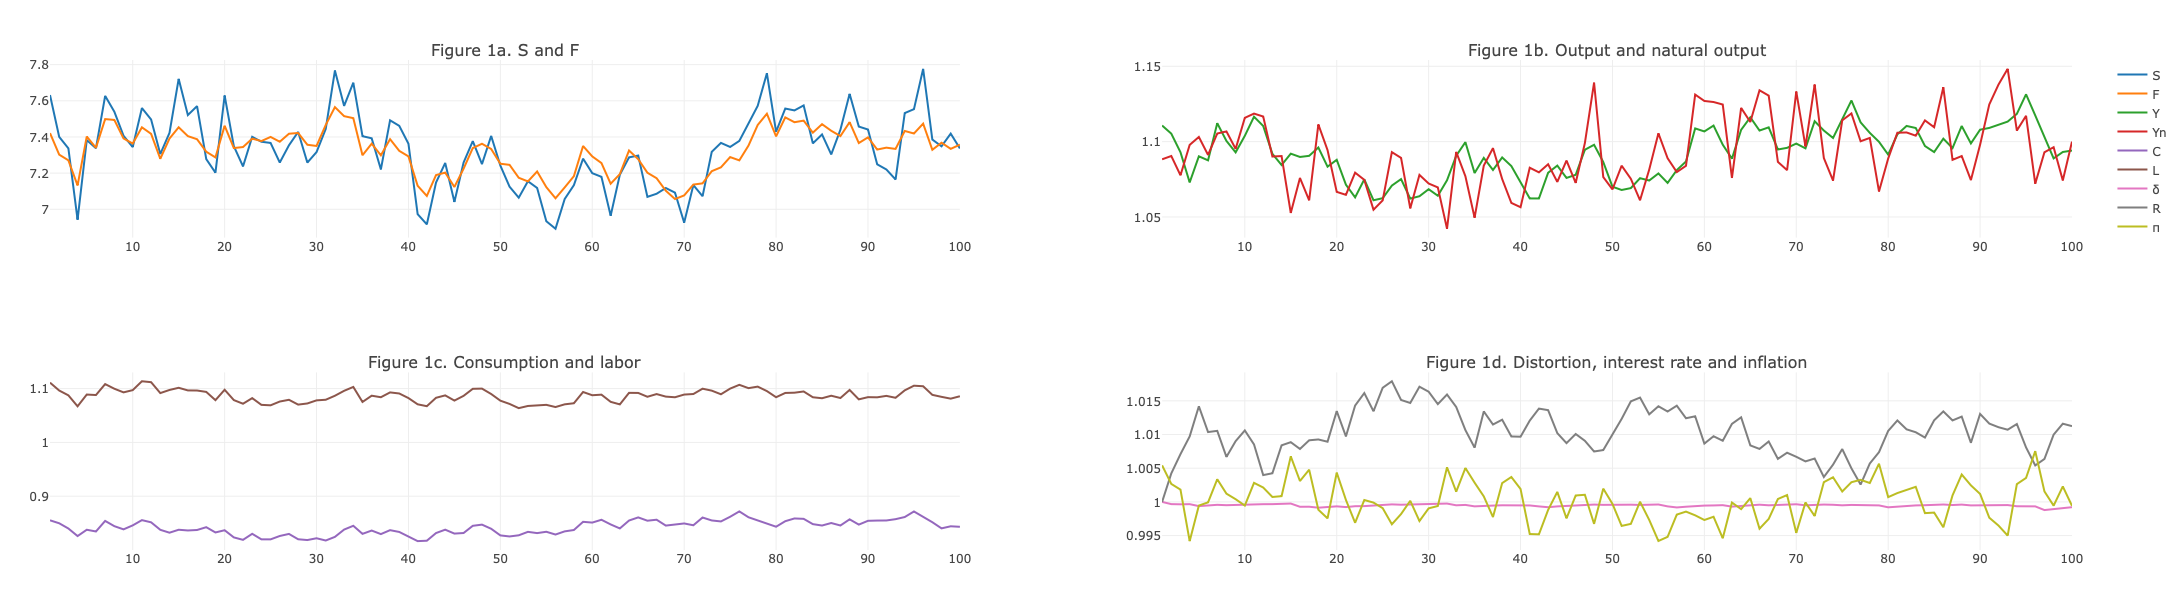

In [14]:
if "table" in ARGS
    build_paper_table()
else
    results = main()
    results[1]  # show plot
end